# Salary predictions using supervised learning
## Sofia Gambirasio
______________________________________________________________________________________________________

**Disclamer** the data used in this project is not from an official statistics source since it is microdata and this is not a research project. Therefore there is no intent in drowing general conclusions, but it will be used merely as an exercise. 
______________________________________________________________________________________________________
### Importing the data 

As first I import a dataset from Kaggle that contains microdata about the salaries of individuals, according to some demographics: `Age`, `Gender`, `Education level`, `Job title`, `Years of experience`, `Country and Race`. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import data
sal = pd.read_csv('C:\\Users\\sofia\\OneDrive\\Desktop\\Lavoro\\Portfolio\\machine learning py\\Salary_Data_Based_country_and_race.csv')
print(sal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6704 non-null   int64  
 1   Age                  6702 non-null   float64
 2   Gender               6702 non-null   object 
 3   Education Level      6701 non-null   object 
 4   Job Title            6702 non-null   object 
 5   Years of Experience  6701 non-null   float64
 6   Salary               6699 non-null   float64
 7   Country              6704 non-null   object 
 8   Race                 6704 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 471.5+ KB
None


### Data preparation 
I rename some column to make them more easy to work with, I drop the Unnamed: 0 column which contains indexes because the table already has an index column. 

In [4]:
sal= sal.drop('Unnamed: 0', axis = 1)
sal= sal.rename(columns = {'Education Level':'Edu_level'})
sal= sal.rename(columns = {'Job Title':'Job_title'})
sal= sal.rename(columns = {'Years of Experience':'Years_experience'})

I look for missing values: they are few, therefore I remove the 6 rows that contain them. 

In [5]:
# look for missing values
print(sal.isna().sum())
# 5% of missing values are...
print(len(sal)*0.05)
# all variables have a low level of missing values.
# the easiest thing is to remove the rows with missing values, since they are few
sal = sal.dropna()

Age                 2
Gender              2
Edu_level           3
Job_title           2
Years_experience    3
Salary              5
Country             0
Race                0
dtype: int64
335.20000000000005


## Exploratory analysis 
In this section, I study the distribution of the variables to discover how the sample is composed, but more importantly I will investigate if the variables that we have, affect the salary level. If not, we will drop them to reduce noise. 
### `Job_title`
There are 191 different job titles in the dataset, but many of them only refer to few individuals. Therefore I decide to keep only the jobs that at least 100 individuals have. In this way we reach 18 relevant jobs. From the boxplot we can appreciate how, predictively, that different job titles are connected with different salary levels. 
We then keep this variable and move to one-hot encoding.

Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          308
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: Job_title, dtype: int64
from 191 to 18 jobs


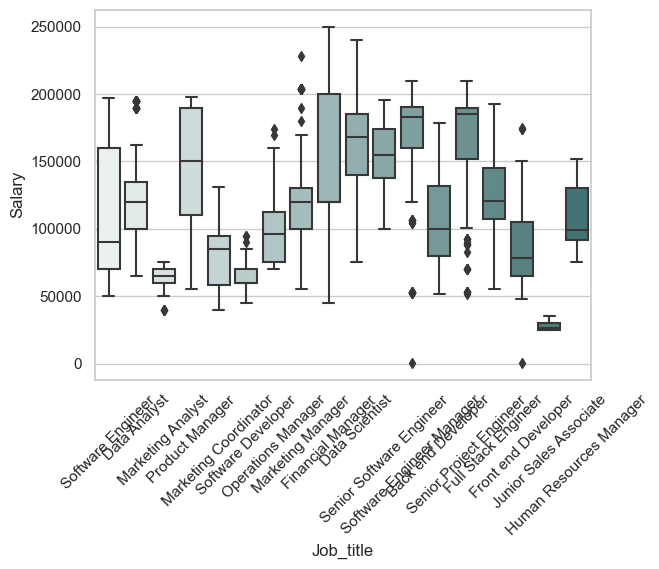

In [6]:
job_counts = sal['Job_title'].value_counts()
# create dataframe with job_counts
job_counts_df = pd.DataFrame({'job':job_counts.index, 'count':job_counts.values})
# we just want the jobs which have minimum 100 obs

# create list with the jobs with more than 100 units
keep_jobs = job_counts_df[job_counts_df['count']>=100]['job'].tolist()
# select the rows in sal which have the filtered jobs
sal = sal[sal['Job_title'].isin(keep_jobs)]
job_counts_aft = sal['Job_title'].value_counts()
print(sal['Job_title'].value_counts())
print(f'from {len(job_counts)} to {len(job_counts_aft)} jobs')

# boxplot
shade_green = sns.color_palette(sns.light_palette('#3C7B7B', n_colors=18))
sns.set(style = 'whitegrid')
sns.set_palette(shade_green)
sns.boxplot(data = sal, x = 'Job_title', y = 'Salary')
plt.xticks(rotation = 45)
plt.show()

# encoding 
sal = pd.get_dummies(sal, columns = ['Job_title'], prefix = 'J')

### `Years_experience`
The variable `Years_experience` is strongly correlated (**0.935**) with the `Age`. However, Years_experience is more correlated with Salary than age, so we drop age to avoid redundancies. 

In [7]:
print(sal[['Salary','Age','Years_experience']].corr())
# drop 
sal = sal.drop('Age', axis = 1)

                    Salary       Age  Years_experience
Salary            1.000000  0.709662          0.766460
Age               0.709662  1.000000          0.936549
Years_experience  0.766460  0.936549          1.000000


Now, we plot the distribution of the years of experience and we notice that the majority of the data is between 4 and 12 years and there are some upper outliers that we proceed to remove. 
Lastly, we don't proceed to represent the relationship between Years_experience and Salary because we already know that there is a correlation of **0.76**

lower quartile: 4.0, higher quartile: 12.0


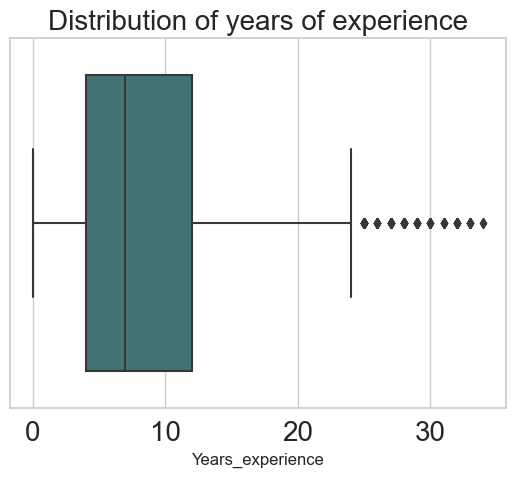

old minimum: 0.0, old_maximum:34.0
new minimum: 0.0, new_maximum:24.0


In [8]:
# boxplot 
Q1 = sal['Years_experience'].quantile(0.25)
Q3 = sal['Years_experience'].quantile(0.75)
print(f'lower quartile: {Q1}, higher quartile: {Q3}')
sns.set(style = 'whitegrid')
b = sns.boxplot(x = 'Years_experience', data = sal, color = '#3C7B7B')
b.set_title('Distribution of years of experience', fontsize = 20)
b.tick_params(axis='x', labelsize=20)
plt.show()

# get rid of the outliers 
IQR = Q3 - Q1
lim1 = Q1-1.5*IQR
lim3 = Q3+1.5*IQR
print(f'old minimum: {sal["Years_experience"].min()}, old_maximum:{sal["Years_experience"].max()}')
sal = sal[(sal['Years_experience']<=lim3) & (sal['Years_experience']>=lim1)]
print(f'new minimum: {sal["Years_experience"].min()}, new_maximum:{sal["Years_experience"].max()}')

### `Gender`
Firstly we notice that there are 3 gender groups: Male, Female, Other. For the sake of statistics, we drop the "Other" category, because with only 12 entries on over 5000 it wouldn't be representative. 
Then we can se from the boxplot that in this dataset there is a gender gap even if small: female tend to earn less than male. Lastly we encode the variable as a dummy and save it in `Gender_e`

Male      2505
Female    1933
Other        8
Name: Gender, dtype: int64


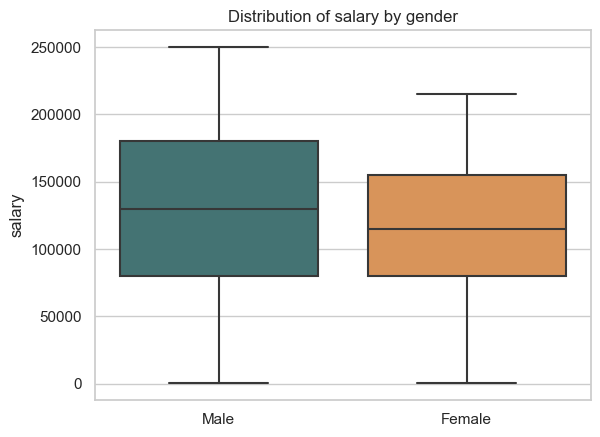

In [9]:
print(sal['Gender'].value_counts())
# 14 individuals is really small for the group other, so we drop the units of this category
sal = sal[sal['Gender']!='Other']

# boxplot 
palette = ['#3C7B7B','#ED9345']
sns.set(style = 'whitegrid')
sns.set_palette(palette)
b = sns.boxplot(data = sal, x = 'Gender', y = 'Salary')
b.set_title('Distribution of salary by gender')
b.set(xlabel = None, ylabel = 'salary')
plt.show()

# encoding
sal['Gender_e'] = sal['Gender'].apply(lambda val: 1 if val=='Female' else 0)

### `Education level`
We notice that there are some titles that are written in different ways (ex. Master, master's degree...) therefore we uniform the names and look at the frequencies of titles in the frequency table. 
Secondly we observe from the boxplot that the education level seems to have a significant role in determining the salary. Lastly we encode the variable in an ordinal way and save it in `Edu_e`, where the smaller number represents the lower educational level (high school<master).

Bachelor       2091
Master         1362
PhD             818
High School     167
Name: Edu_level, dtype: int64


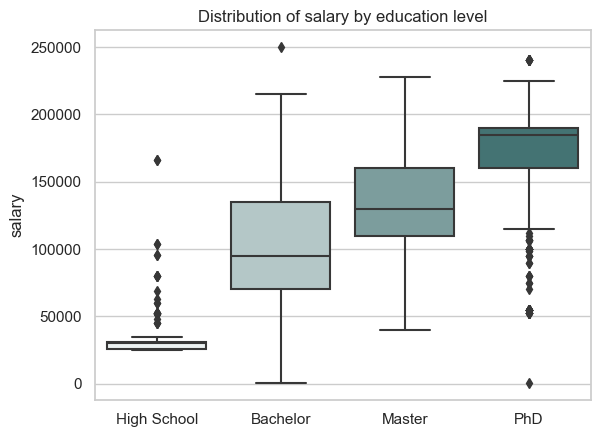

In [10]:
sal.loc[sal['Edu_level'].isin(['Bachelor\'s', 'Bachelor\'s Degree']),'Edu_level'] = 'Bachelor'
sal.loc[sal['Edu_level'] == 'phD','Edu_level'] = 'PhD'
sal.loc[sal['Edu_level'].isin(['Master\'s', 'Master\'s Degree']),'Edu_level'] = 'Master'

# frequency counts
print(sal['Edu_level'].value_counts())

# boxplot
ord_edu = ['High School','Bachelor','Master','PhD']
shade_green = sns.color_palette(sns.light_palette('#3C7B7B', n_colors=4))
sns.set(style = 'whitegrid')
sns.set_palette(shade_green)
b = sns.boxplot(x = 'Edu_level', y = 'Salary', data = sal, order = ord_edu)
b.set_title('Distribution of salary by education level')
b.set(xlabel = None, ylabel = 'salary')
plt.show()

# encoding 
sal['Edu_e'] = sal['Edu_level'].map({'High School':1, 'Bachelor':2, 'Master':3, 'PhD':4})

### `Country`
Just with a simple frequency count we see that the entries are equally distributed among the countries. Moreover, since we notice from the boxplots that there is no relevant difference of salaries across countries, therefore we drop this variable to reduce noise. 

USA          919
UK           895
Australia    879
China        873
Canada       872
Name: Country, dtype: int64


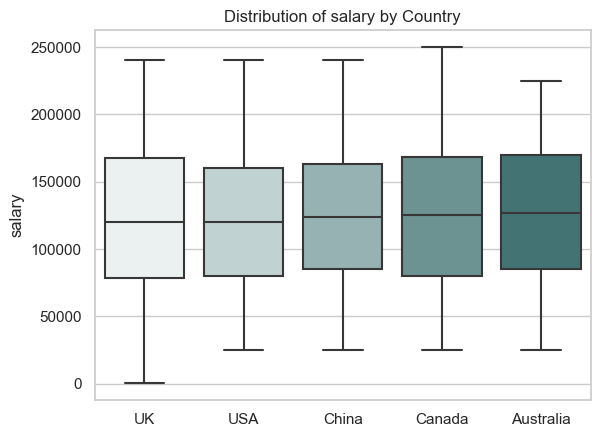

In [11]:
print(sal['Country'].value_counts())

# boxplot
shade_green = sns.color_palette(sns.light_palette('#3C7B7B', n_colors=5))
sns.set(style = 'whitegrid')
sns.set_palette(shade_green)
b = sns.boxplot(x = 'Country', y = 'Salary', data = sal)
b.set_title('Distribution of salary by Country')
b.set(xlabel = None, ylabel = 'salary')
plt.show()

sal = sal.drop('Country', axis = 1)

### `Race`
We can see in the frequency count and the bar plot that the races are all well represented even though white and asian have significantly more units. Then we see in the boxplots that there are small differences in the distribution of salary among races, so we keep them and we encode with the one-hot encoding.

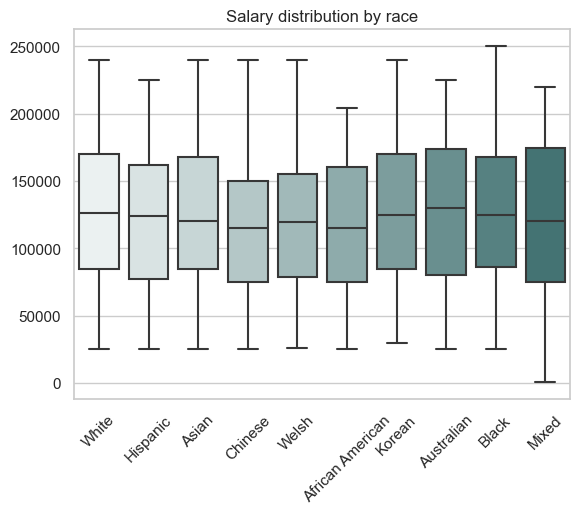

White               1290
Asian               1079
Korean               312
Australian           293
Chinese              283
Black                278
African American     245
Mixed                226
Hispanic             216
Welsh                216
Name: Race, dtype: int64


In [12]:
# boxplots 
race_ord = sal['Race'].value_counts().index
shade_green = sns.color_palette(sns.light_palette('#3C7B7B', n_colors=10))
sns.set_palette(shade_green)
c = sns.boxplot(x = 'Race', y = 'Salary', data = sal)
sns.set(style = 'whitegrid')
c.set_title('Salary distribution by race')
c.set(xlabel = None, ylabel = None)
plt.xticks(rotation = 45)
plt.show()
print(sal['Race'].value_counts())


# encoding 
sal = pd.get_dummies(sal, columns = ['Race'], prefix = 'R')

### `Salary`
From the distribution of salary we don't see outliers.

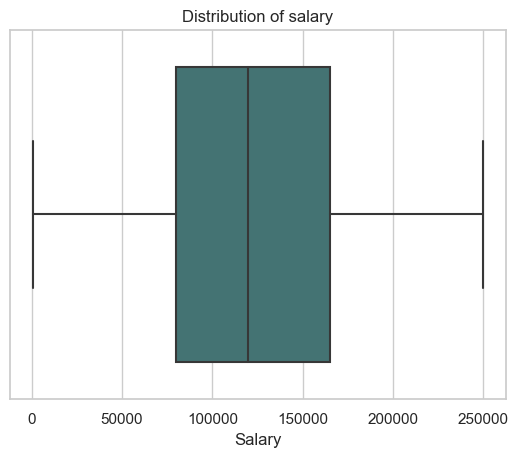

In [13]:
sns.set(style = 'whitegrid')
h = sns.boxplot(x = 'Salary', data = sal, color = '#3C7B7B')
h.set_title('Distribution of salary')
h.set(ylabel = None)
plt.show()

# Exporting the dataset 
I finally export the modified dataset in csv in order to do machine learning predictions in R

In [14]:
sal.info()
sal.to_csv('C:\\Users\\sofia\\OneDrive\\Desktop\\Lavoro\\Portfolio\\machine learning py\\salary_mod.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4438 entries, 0 to 6702
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       4438 non-null   object 
 1   Edu_level                    4438 non-null   object 
 2   Years_experience             4438 non-null   float64
 3   Salary                       4438 non-null   float64
 4   J_Back end Developer         4438 non-null   uint8  
 5   J_Data Analyst               4438 non-null   uint8  
 6   J_Data Scientist             4438 non-null   uint8  
 7   J_Financial Manager          4438 non-null   uint8  
 8   J_Front end Developer        4438 non-null   uint8  
 9   J_Full Stack Engineer        4438 non-null   uint8  
 10  J_Human Resources Manager    4438 non-null   uint8  
 11  J_Junior Sales Associate     4438 non-null   uint8  
 12  J_Marketing Analyst          4438 non-null   uint8  
 13  J_Marketing Coordi